In [4]:
# Visualizes results

#list dir for all the log files 
import glob
import matplotlib.pyplot as plt
import os
from collections import defaultdict, OrderedDict
import numpy as np
import json
import math 
import ast

def getkey_gtfix(f):
    gt = f[f.find('pred_label_gt')+len('pred_label_gt'):f.find('pred_label_gt')+len('pred_label_gt')+4] 
    return int(gt[-2:-1])

def getkey_pfix(f):
    gt = f[f.find('pred_label_gt')+len('pred_label_gt'):f.find('pred_label_gt')+len('pred_label_gt')+2] 
    x = f.find('pred_label')
    if gt == '5p':
        return 5
    return int(gt)


met = ['AP-' + cat for cat in ['chair', 'cushion', 'indoor-plant', 'door', 'table', 'sofa']]
met.insert(0, 'AP')
  

def plot(bboxa1, bboxa2, bboxd, segma1, segma2, segmd, xlabel):
    
    def unpack(x):
        res = []
        err = []
        for k, v in x.items():
            res.append(v['mean'])
            err.append(v['std'])
        return res, err
    
    a1, b1 = unpack(bboxa1)
    a2, b2 = unpack(bboxa2)
    
    c, d = unpack(bboxd)
    
    # always plot keys on the x-axis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), dpi=100)
    ax1.set_title('bbox')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('AP50')
    ax1.errorbar(bboxa1.keys(), a1, yerr=b1, label='straightline')
    ax1.errorbar(bboxa2.keys(), a2, yerr=b2, label='circle')
    ax1.errorbar(bboxd.keys(), c, yerr=d, label='baseline')
    ax1.legend(loc="upper left", prop={'size':6})

    a1, b1 = unpack(segma1)
    a2, b2 = unpack(segma2)
    c, d = unpack(segmd)
    
    
    ax2.set_title(f'segm')
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('AP50')
    ax2.errorbar(segma1.keys(), a1, yerr=b1, label='straightline')
    ax2.errorbar(segma2.keys(), a2, yerr=b2, label='circle')
    ax2.errorbar(segmd.keys(), c, yerr=d, label='baseline')
    ax2.legend(loc="upper left", prop={'size':7})

    plt.show()
    
class MeanVar:
    def __init__(self, arr):
        self.arr = arr
        self.mean = np.mean(arr)
        self.var = np.var(arr)

class HyperParams:
    def __init__(self, lr, warmup, iters):
        self.lr = lr
        self.warmup = warmup
        self.iters = iters
        
    def __eq__(self, other): 
        if not isinstance(other, HyperParams):
            # don't attempt to compare against unrelated types
            return NotImplemented
        return self.lr == other.lr and self.warmup == other.warmup and self.iters == other.iters
    
    def setAP(self, bbox, segm):
        self.bbox = bbox
        self.segm = segm
    
    def get_file_name_pref(self):
        return f'{self.lr} {self.warmup} {self.maxiters} *.txt'
    
    def __repr__(self):
        return f'lr {self.lr} warmup {self.warmup} iters {self.iters}'
    
def process_hpm(x):
    x = x.strip()
    x = x.split()
    print(x)
    assert len(x) == 6
    return HyperParams(lr=float(x[1]), warmup=int(x[3]), iters=int(x[5]))

def process_met(x):
#     x = x.strip()
#     print(x)
#     x = ast.literal_eval(x)
    x = json.loads(x)
#     assert type(x) == dict
#     print(type(x), x)
    for k, v in x.items():
#         print(k, v)
        if 'val' in k:
            return v['bbox']['AP'], v['segm']['AP']


def get_best_test_ap(outdir):
#     print(f'read_results {outdir}')
    bbox, segm = get_best_hyperparam_file(outdir)
    return MeanVar([bbox]), MeanVar([segm])
    

def load_json_arr(json_path):
    lines = []
    # print(f'looking at {json_path}')
    with open(json_path, 'r') as f:
        ls = f.readlines()
        for line in ls:
            try:
                # print(len(line), line)
                lines.append(json.loads(line))
            except json.JSONDecodeError:
                # print(f'JSONDecodeError {len(line), line[:2]}')
                continue
    return lines


def process(l, f):
    def get_val_key(l):
        l = l.split('/')       
        k = l[-7] + '/' + l[-6] + '_val' + l[-5]
#         print(k)
        return k

    def get_test_key(l):
        l = l.split('/')
        k = l[-7] + '/' + l[-6] + '_test_0_' + l[-5]
        # print(k)
        return k
    
    val_key = get_val_key(f)
    test_key = get_test_key(f)
    
    keys = [
        'iteration', 
        'validation_loss', 
        f'{val_key}/bbox/AP', 
        f'{val_key}/segm/AP',
        f'{test_key}/bbox/AP', 
        f'{test_key}/segm/AP'
    ]
    
#     print(f'{l}, val_key {val_key}, test_key {test_key}')
#     print(keys)
    vals = {}
    for k in keys:
        if k in l:
            if k == f'{val_key}/bbox/AP':
                vals.update({'val/bbox':l[k]})
            elif k == f'{val_key}/segm/AP':
                vals.update({'val/segm':l[k]})
            elif k == f'{test_key}/bbox/AP':
                vals.update({'test/bbox':l[k]})
            elif k == f'{test_key}/segm/AP':
                vals.update({'test/segm':l[k]})
            else:
                vals.update({k:l[k]})
    
#     if len(vals) > 1:
#     print(vals)
    return vals

# def process(l, f):
#     def get_val_key(l):
#         l = l.split('/')
#         k = l[-6] + '_val' + l[-5]
#         # print(l, k)
#         return k
    
        
#     keys = ['iteration', 'validation_loss', f'{get_val_key(f)}/bbox/AP', f'{get_val_key(f)}/segm/AP']
#     vals = {}
#     for k in keys:
#         if k in l:
# #             print(l[k])
#             if k == f'{get_val_key(f)}/bbox/AP':
#                 vals.update({'bbox':l[k]})
#             elif k == f'{get_val_key(f)}/segm/AP':
#                 vals.update({'segm':l[k]})
#             else:
#                 vals.update({k:l[k]})
    
#     return vals

def get_best_hyperparam_file(outdir):
    metric_jsons = glob.glob(outdir + '/**/metrics.json', recursive=True) # get all the validation files
    # print(f'globbed {len(metric_jsons)} metric jsons {metric_jsons}')
    best_val = 1000000
    best_bbox = 0
    best_segm = 0
    bb = 0
    ss = 0
    for m in metric_jsons:
        
        x = load_json_arr(m)
        
        for l in x:
            vals = process(l, m)
            
            if 'validation_loss' in vals and 'val/bbox' in vals and 'test/bbox' in vals:
#                 if vals['val/bbox'] + vals['val/segm'] > best_val_ap:
#                     bb = vals['test/bbox']
#                     ss = vals['test/segm']
#                     best_val_ap = bb + ss
                    
#                 print(vals)
                val_loss = vals['validation_loss']
                if val_loss < best_val:
                    bb = vals['test/bbox']
                    ss = vals['test/segm']
                    best_val = val_loss

            
#             if 'validation_loss' in vals and 'bbox' in vals and 'segm' in vals:
#                 print(f'vals {vals}')
#                 bb = vals['bbox']
#                 ss = vals['segm']
# #                 if bb+ss > best_segm+best_bbox:
# #                     best_bbox = bb
# #                     best_segm = ss
                
#                 val_loss = vals['validation_loss']
#                 if val_loss < best_val:
#                     best_bbox = bb
#                     best_segm = ss
                    
    
    return bb, ss

def alphametrics(arrs, vis=False):
    # just take the overall average
#     print(f'alphametrics for {arrs}')
    r = []
    for x in arrs:
        r.append(x.arr)
    r = [item for sublist in r for item in sublist]
#     print(f'{len(r)} samples {r}')
    if vis:
        sns.kdeplot(r)
        plt.show()
    return np.mean(r), np.var(r), len(r)

def get_meanvar_for_alltraj_gtxpy(job_root, gt, p, metric, num_samples):
    bbox = []
    segm = []
    for x in range(10):
        pth = os.path.join(job_root, 'code/output_droid', str(x), f'pred_label_gt{gt}p{p}')
        #     print(pth)

        if os.path.isdir(pth):
            # print(f'{pth} found')
            # check if this is a valid folder 
            for x in range(num_samples):
                sp = os.path.join(pth, str(x))
                bb, se = get_best_test_ap(sp)
                if bb and se:
                    bbox.append(bb)
                    segm.append(se)            
    
    return alphametrics(bbox), alphametrics(segm) 

def get_all(job_root, gts, ps, metric, num_samples):
    bbox = defaultdict(lambda: defaultdict(int))
    segm = defaultdict(lambda: defaultdict(int))
    if len(ps) == 1:
        for gt in gts:
            bb, se = get_meanvar_for_alltraj_gtxpy(job_root, gt, ps[0], metric, num_samples)
#             print(f'gt {gt}, p {ps[0]}, bbox {bb[0]}, segm {se[0]}, bbox samples {bb[2]}, segm samples {se[2]}')
            bbox[gt]['mean'], bbox[gt]['std'] = bb[0], math.sqrt(bb[1])
            segm[gt]['mean'], segm[gt]['std'] = se[0], math.sqrt(se[1])
            
    if len(gts) == 1:
        for p in ps:
            bb, se = get_meanvar_for_alltraj_gtxpy(job_root, gts[0], p, metric, num_samples)
#             print(f'gt {gts[0]}, p {p}, bbox {bb[0]}, segm {se[0]}, bbox samples {bb[2]}, segm samples {se[2]}\n\n')
            bbox[p]['mean'], bbox[p]['std'] = bb[0], math.sqrt(bb[1])
            segm[p]['mean'], segm[p]['std'] = se[0], math.sqrt(se[1])
            
    return bbox, segm


def compare(job_root_act1, job_root_act2, job_root_baseline, gts, ps, metric, xlabel, num_samples):
    bm_act1, sm_act1 = get_all(job_root_act1, gts, ps, metric, num_samples)
    bm_act2, sm_act2 = get_all(job_root_act2, gts, ps, metric, num_samples)
    bm_def, sm_def = get_all(job_root_baseline, gts, ps, metric, num_samples)
    plot(bm_act1, bm_act2, bm_def, sm_act1, sm_act2, sm_def, xlabel)


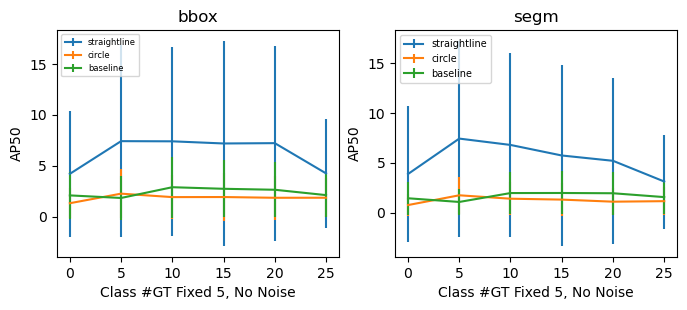

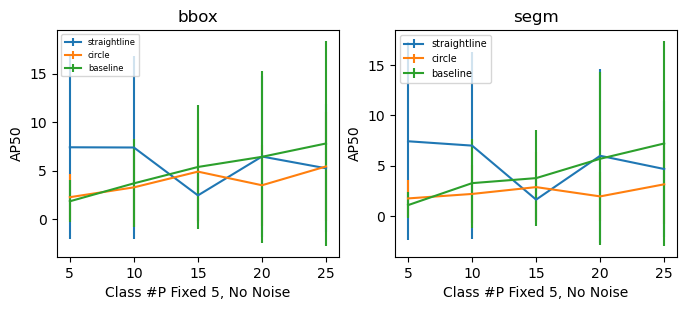

/private/home/apratik/miniconda3/envs/droidlet/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/private/home/apratik/miniconda3/envs/droidlet/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/private/home/apratik/miniconda3/envs/droidlet/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/private/home/apratik/miniconda3/envs/droidlet/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/private/home/apratik/miniconda3/envs/droidlet/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/private/home/apratik/miniconda3/envs/droidlet/lib/python3.7/site-packages/numpy/core/_meth

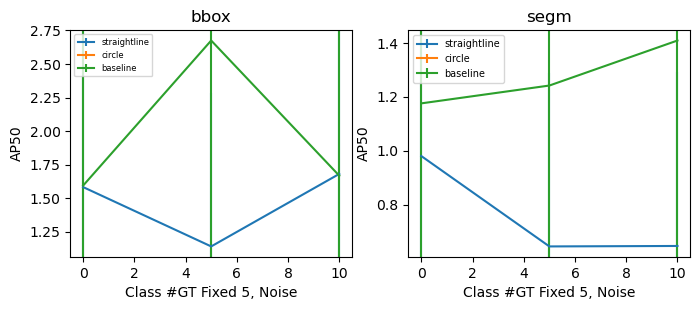

/private/home/apratik/miniconda3/envs/droidlet/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/private/home/apratik/miniconda3/envs/droidlet/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/private/home/apratik/miniconda3/envs/droidlet/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/private/home/apratik/miniconda3/envs/droidlet/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/private/home/apratik/miniconda3/envs/droidlet/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/private/home/apratik/miniconda3/envs/droidlet/lib/python3.7/site-packages/numpy/core/_meth

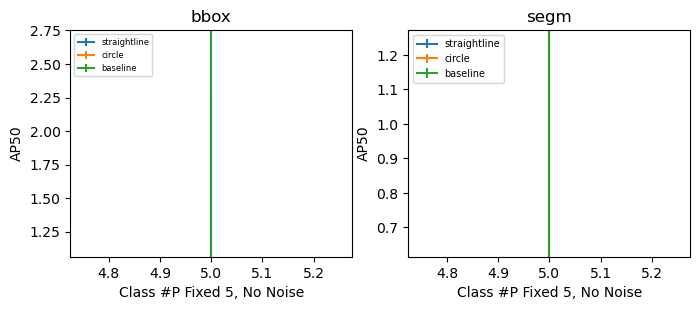

In [5]:
st_n = '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/class/straightline/noise/27-12-2021/22:52:03'
ci_n = '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/class/circle/noise/27-12-2021/22:47:10'
base_n = '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/class/baseline/noise/27-12-2021/22:39:16'
st = '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/class/baseline/no_noise/27-12-2021/22:27:33'
base = '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/class/baseline/no_noise/27-12-2021/22:04:18'
ci = '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/class/circle/no_noise/27-12-2021/22:16:18'


compare(
    # '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/22-12-2021/12:42:02/', 
    st, ci, base,
    [5], [0, 5,10,15,20,25], metric='alpha', xlabel=f'Class #GT Fixed {5}, No Noise', num_samples=2
)

compare(
    # '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/22-12-2021/12:42:02/', 
    st, ci, base,
    [5,10,15,20,25], [5], metric='alpha', xlabel=f'Class #P Fixed {5}, No Noise', num_samples=2
)

compare(
    st_n, ci_n, base_n,
    [5], [0, 5,10,15,20,25], metric='alpha', xlabel=f'Class #GT Fixed {5}, Noise', num_samples=2
)

compare(
    st_n, ci_n, base_n,
    [5,10,15,20,25], [5], metric='alpha', xlabel=f'Class #P Fixed {5}, No Noise', num_samples=2
)